# House prices

Kairos (April 2018)

## Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

## Data
79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

## Challenge
Predicting the final price of each home.

## Method
We'll use Tensorflow as out method to develop the project.

# Improving Neural Net Performance

Learning Objective: Improve the performance of a neural network by normalizing features and applying various optimization algorithms

NOTE: The optimization methods described in this exercise are not specific to neural networks; they are effective means to improve most types of models.

## 1. Set Up
In this first cell, we'll load the necessary libraries.

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2. Load our data set
Next, we'll load our data set and show information about it.

In [2]:
housing_dataframe = pd.read_csv("input/cleaned_houses_prices_train.csv", sep=",")
housing_dataframe.shape
housing_dataframe.describe()
housing_dataframe.info()
housing_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 65 columns):
Id               1451 non-null int64
MSSubClass       1451 non-null int64
LotArea          1451 non-null int64
OverallQual      1451 non-null int64
OverallCond      1451 non-null int64
YearBuilt        1451 non-null int64
YearRemodAdd     1451 non-null int64
MasVnrArea       1451 non-null float64
BsmtFinSF1       1451 non-null int64
BsmtFinSF2       1451 non-null int64
BsmtUnfSF        1451 non-null int64
TotalBsmtSF      1451 non-null int64
1stFlrSF         1451 non-null int64
2ndFlrSF         1451 non-null int64
LowQualFinSF     1451 non-null int64
GrLivArea        1451 non-null int64
BsmtFullBath     1451 non-null int64
BsmtHalfBath     1451 non-null int64
FullBath         1451 non-null int64
HalfBath         1451 non-null int64
BedroomAbvGr     1451 non-null int64
KitchenAbvGr     1451 non-null int64
TotRmsAbvGrd     1451 non-null int64
Fireplaces       1451 non-null int64
Gar

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,0,0,0,0,0,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,1,0,0,0,0,1,0,0,0,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,0,0,0,0,0,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,2,0,1,0,0,0,0,0,0,1
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1456,60,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1447,1457,20,13175,6,6,1978,1988,119.0,790,163,...,1,0,2,0,0,1,1,0,0,0
1448,1458,70,9042,7,9,1941,2006,0.0,275,0,...,5,0,0,0,0,0,0,0,0,0
1449,1459,20,9717,5,6,1950,1996,0.0,49,1029,...,1,0,1,0,2,0,0,0,0,0


In [3]:
# Create a synthetic feature.
# Create a new category for total habitable surface
housing_dataframe["habitableSF"] = housing_dataframe["1stFlrSF"] + housing_dataframe["2ndFlrSF"] + housing_dataframe["GrLivArea"]
#housing_dataframe['SQMeter_price'] = housing_dataframe.apply(lambda row: row['SalePrice'] / row['habitableSF'], axis=1)
housing_dataframe['SQMeter_price'] = 0  

In [4]:
def preprocess_features(housing_dataframe):
  """Prepares input features from housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = housing_dataframe[
    ["MSZoning",
     "YearRemodAdd",
     "Utilities",
     "Neighborhood",
     "HouseStyle",
     "BedroomAbvGr",
     "OverallCond"]]
  processed_features = selected_features.copy()
  
 
  # Create a new synthetic feature
  processed_features['SQMeter_price'] = ( 
    housing_dataframe['SalePrice'] / 
    housing_dataframe['habitableSF'])

  return processed_features

def preprocess_targets(housing_dataframe):
  """Prepares target features (i.e., labels) from housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["SalePrice"] = (
    housing_dataframe["SalePrice"])
  return output_targets

## 3. Splitting

In [5]:
# Choose the first 1000 (out of 1451) examples for training.
training_examples = preprocess_features(housing_dataframe.head(1000))
training_targets = preprocess_targets(housing_dataframe.head(1000))

# Choose the last 500 (out of 1451) examples for validation.
validation_examples = preprocess_features(housing_dataframe.tail(500))
validation_targets = preprocess_targets(housing_dataframe.tail(500))

# Double-check that we've done the right thing.
print "Training examples summary:"
display.display(training_examples.describe())
print "Validation examples summary:"
display.display(validation_examples.describe())

print "Training targets summary:"
display.display(training_targets.describe())
print "Validation targets summary:"
display.display(validation_targets.describe())

Training examples summary:


,MSZoning,YearRemodAdd,Utilities,Neighborhood,HouseStyle,BedroomAbvGr,OverallCond,SQMeter_price
count,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,0.4,1985.1,0.0,9.5,1.1,2.9,5.6,60.8
std,0.8,20.4,0.0,5.8,1.3,0.8,1.1,15.5
min,0.0,1950.0,0.0,0.0,0.0,0.0,1.0,15.2
25%,0.0,1967.0,0.0,5.0,0.0,2.0,5.0,50.7
50%,0.0,1994.0,0.0,10.0,1.0,3.0,5.0,60.2
75%,0.0,2004.0,0.0,13.0,1.0,3.0,6.0,69.3
max,4.0,2010.0,1.0,24.0,7.0,8.0,9.0,138.1


Validation examples summary:


,MSZoning,YearRemodAdd,Utilities,Neighborhood,HouseStyle,BedroomAbvGr,OverallCond,SQMeter_price
count,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0
mean,0.3,1983.8,0.0,9.3,1.2,2.9,5.6,59.3
std,0.8,21.2,0.0,6.0,1.3,0.8,1.1,15.7
min,0.0,1950.0,0.0,0.0,0.0,0.0,3.0,14.2
25%,0.0,1964.8,0.0,5.0,0.0,2.0,5.0,49.0
50%,0.0,1992.0,0.0,9.0,1.0,3.0,5.0,59.2
75%,0.0,2004.0,0.0,14.0,1.0,3.0,6.0,68.9
max,4.0,2010.0,0.0,24.0,7.0,6.0,9.0,118.8


Training targets summary:


,SalePrice
count,1000.0
mean,181962.4
std,80430.9
min,34900.0
25%,130000.0
50%,162950.0
75%,215000.0
max,755000.0


Validation targets summary:


,SalePrice
count,500.0
mean,176991.2
std,76270.3
min,37900.0
25%,128975.0
50%,160000.0
75%,203000.0
max,745000.0


# 4. Building a Neural Network

The NN is defined by the [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) class.

Use **`hidden_units`** to define the structure of the NN.  The `hidden_units` argument provides a list of ints, where each int corresponds to a hidden layer and indicates the number of nodes in it.  For example, consider the following assignment:

`hidden_units=[3,10]`

The preceding assignment specifies a neural net with two hidden layers:

* The first hidden layer contains 3 nodes.
* The second hidden layer contains 10 nodes.

If we wanted to add more layers, we'd add more ints to the list. For example, `hidden_units=[10,20,30,40]` would create four layers with ten, twenty, thirty, and forty units, respectively.

By default, all hidden layers will use ReLu activation and will be fully connected.

In [6]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [7]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [22]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["SalePrice"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["SalePrice"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["SalePrice"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print "Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error
  print "Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error

  return dnn_regressor, training_rmse, validation_rmse

## Task 1: Train a NN Model

**Adjust hyperparameters, aiming to drop RMSE below 110.**

Run the following block to train a NN model.  

Recall that in the linear regression exercise with many features, an RMSE of 185000 or so was pretty good.  We'll aim to beat that.

Your task here is to modify various learning settings to improve accuracy on validation data.

Overfitting is a real potential hazard for NNs.  You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting.

Because of the number of different possible settings, it's strongly recommended that you take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.


NOTE: This selection of parameters is somewhat arbitrary. Here we've tried combinations that are increasingly complex, combined with training for longer, until the error falls below our objective. This may not be the best combination; others may attain an even lower RMSE. If your aim is to find the model that can attain the best error, then you'll want to use a more rigorous process, like a parameter search.

Training model...
RMSE (on training data):
  period 00 : 185621.21
  period 01 : 115246.32
  period 02 : 79450.12
  period 03 : 79380.50
  period 04 : 79330.84
  period 05 : 79310.32
  period 06 : 79317.58
  period 07 : 79277.18
  period 08 : 79255.73
  period 09 : 79203.66
Model training finished.
Final RMSE (on training data):   79203.66
Final RMSE (on validation data): 75501.83


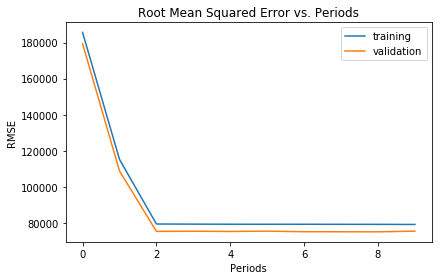

In [26]:
dnn_regressor = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.003),
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Linear Scaling
It can be a good standard practice to normalize the inputs to fall within the range -1, 1. This helps SGD not get stuck taking steps that are too large in one dimension, or too small in another. Fans of numerical optimization may note that there's a connection to the idea of using a preconditioner here.

In [10]:
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = (max_val - min_val) / 2.0
  return series.apply(lambda x:((x - min_val) / scale) - 1.0)

### Task 1: Normalize the Features Using Linear Scaling

**Normalize the inputs to the scale -1, 1.**

**Spend about 5 minutes training and evaluating on the newly normalized data.  How well can you do?**

As a rule of thumb, NN's train best when the input features are roughly on the same scale.

Sanity check your normalized data.  (What would happen if you forgot to normalize one feature?)

Since normalization uses min and max, we have to ensure it's done on the entire dataset at once.

We can do that here because all our data is in a single DataFrame. If we had multiple data sets, a good practice would be to derive the normalization parameters from the training set and apply those identically to the test set.

In [27]:
def normalize_linear_scale(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
  processed_features = pd.DataFrame()
  processed_features["MSZoning"] = linear_scale(examples_dataframe["MSZoning"])
  processed_features["YearRemodAdd"] = linear_scale(examples_dataframe["YearRemodAdd"])
  processed_features["Utilities"] = linear_scale(examples_dataframe["Utilities"])
  processed_features["Neighborhood"] = linear_scale(examples_dataframe["Neighborhood"])
  processed_features["HouseStyle"] = linear_scale(examples_dataframe["HouseStyle"])
  processed_features["BedroomAbvGr"] = linear_scale(examples_dataframe["BedroomAbvGr"])
  processed_features["OverallCond"] = linear_scale(examples_dataframe["OverallCond"])
  processed_features["SQMeter_price"] = linear_scale(examples_dataframe["SQMeter_price"])
  

  return processed_features

normalized_dataframe = normalize_linear_scale(preprocess_features(housing_dataframe))
normalized_training_examples = normalized_dataframe.head(1000)
normalized_validation_examples = normalized_dataframe.tail(500)

Training model...
RMSE (on training data):
  period 00 : 189852.23
  period 01 : 130343.00
  period 02 : 70060.34
  period 03 : 65100.65
  period 04 : 61664.10
  period 05 : 58546.47
  period 06 : 55829.19
  period 07 : 53906.29
  period 08 : 52885.92
  period 09 : 52684.33
Model training finished.
Final RMSE (on training data):   52684.33
Final RMSE (on validation data): 52566.84


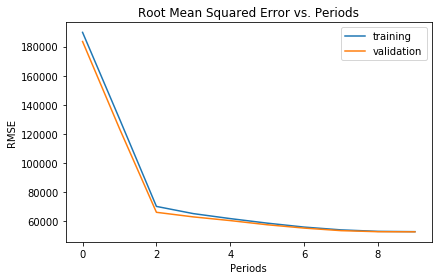

In [29]:
_ = train_nn_regression_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.03),
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

### Task 2: Try a Different Optimizer

** Use the Adagrad and Adam optimizers and compare performance.**

The Adagrad optimizer is one alternative. The key insight of Adagrad is that it modifies the learning rate adaptively for each coefficient in a model, monotonically lowering the effective learning rate.  This works great for convex problems, but isn't always ideal for the non-convex problem Neural Net training.  You can use Adagrad by specifying `AdagradOptimizer` instead of `GradientDescentOptimizer`.  Note that you may need to use a larger learning rate with Adagrad.

For non-convex optimization problems, Adam is sometimes more efficient than Adagrad.  To use Adam, invoke the `tf.train.AdamOptimizer` method. This method takes several optional hyperparameters as arguments, but our solution only specifies one of these (`learning_rate`). In a production setting, you should specify and tune the optional hyperparameters carefully.

**First** let's try Adagrad.

Training model...
RMSE (on training data):
  period 00 : 189915.71
  period 01 : 169741.60
  period 02 : 141341.08
  period 03 : 109177.52
  period 04 : 80123.57
  period 05 : 71590.79
  period 06 : 69778.57
  period 07 : 68796.43
  period 08 : 67561.85
  period 09 : 66506.95
Model training finished.
Final RMSE (on training data):   66506.95
Final RMSE (on validation data): 64391.78


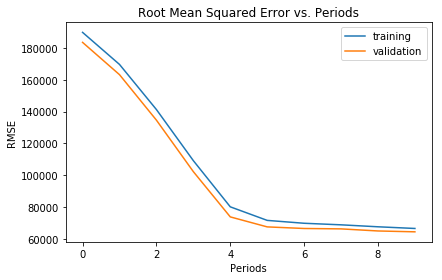

In [31]:
_, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

**Now** let's try Adam.

Training model...
RMSE (on training data):
  period 00 : 71302.77
  period 01 : 49104.47
  period 02 : 44945.49
  period 03 : 42596.56
  period 04 : 41232.69
  period 05 : 41188.68
  period 06 : 41781.38
  period 07 : 39527.96
  period 08 : 40350.58
  period 09 : 39840.07
Model training finished.
Final RMSE (on training data):   39840.07
Final RMSE (on validation data): 41180.15


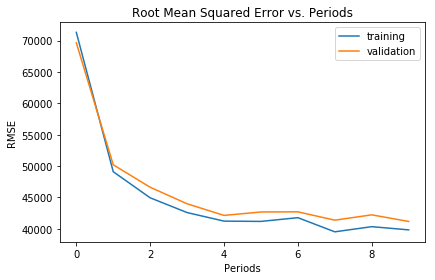

In [33]:
_, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

Let's print a graph of loss metrics side by side.

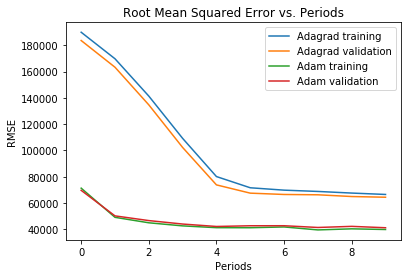

In [34]:
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
_ = plt.legend()

### Task 3: Explore Alternate Normalization Methods

**Try alternate normalizations for various features to further improve performance.**

If you look closely at summary stats for your transformed data, you may notice that linear scaling some features leaves them clumped close to `-1`.

For example, many features have a median of `-0.8` or so, rather than `0.0`.

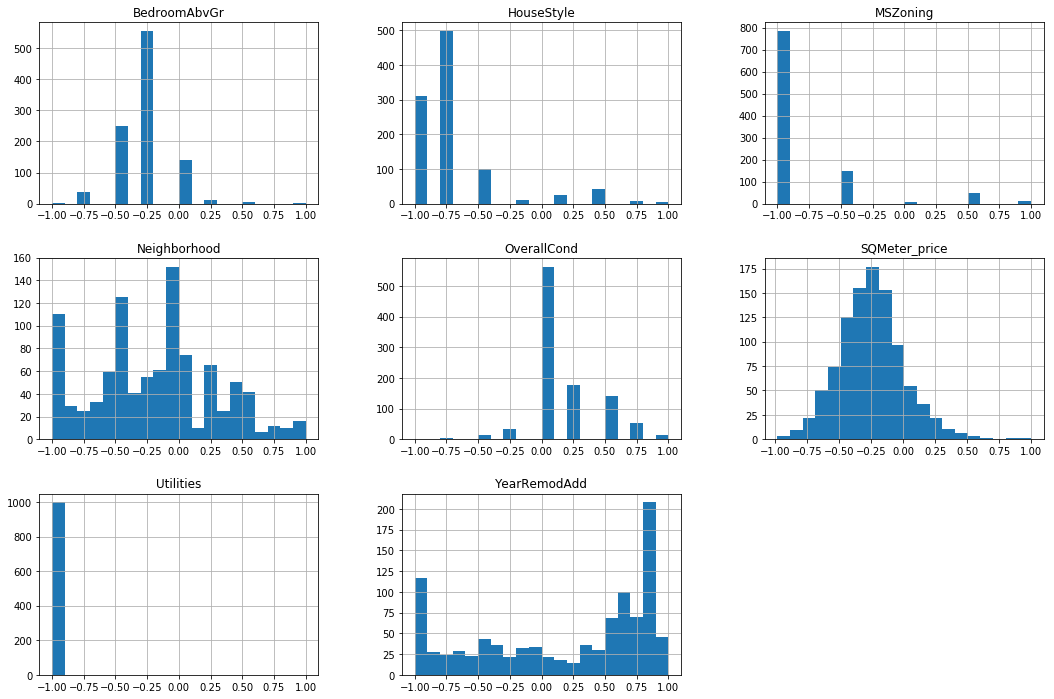

In [35]:
_ = normalized_training_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

We might be able to do better by choosing additional ways to transform these features.

For example, a log scaling might help some features. Or clipping extreme values may make the remainder of the scale more informative.

In [36]:
def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))

The block above contains a few additional possible normalization functions. Try some of these, or add your own.

Note that if you normalize the target, you'll need to un-normalize the predictions for loss metrics to be comparable.

These are only a few ways in which we could think about the data. Other transformations may work even better!

Sqmeter_price and HouseStyle appear normally-distributed in a log space.

Neighborhood, YearRemodAdd and OverAllCond would probably be better off just scaled linearly, as before.

MSZoning, Utilities have a few extreme outliers. They seem too extreme for log normalization to help. So let's clip them instead.



Training model...
RMSE (on training data):
  period 00 : 192451.49
  period 01 : 168414.70
  period 02 : 135819.11
  period 03 : 100352.78
  period 04 : 74961.95
  period 05 : 70289.35
  period 06 : 68711.64
  period 07 : 67803.45
  period 08 : 67028.96
  period 09 : 66366.42
Model training finished.
Final RMSE (on training data):   66366.42
Final RMSE (on validation data): 63677.57


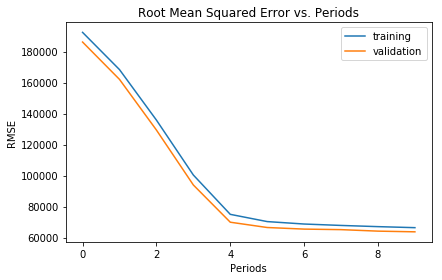

In [42]:
def normalize(examples_dataframe):
  """Returns a version of the input `DataFrame` that has all its features normalized."""
  processed_features = pd.DataFrame()

  processed_features["SQMeter_price"] = log_normalize(examples_dataframe["SQMeter_price"])
  processed_features["HouseStyle"] = log_normalize(examples_dataframe["HouseStyle"])
  
  processed_features["Neighborhood"] = linear_scale(examples_dataframe["Neighborhood"])
  processed_features["YearRemodAdd"] = linear_scale(examples_dataframe["YearRemodAdd"])
  processed_features["OverallCond"] = linear_scale(examples_dataframe["OverallCond"])

  processed_features["MSZoning"] = linear_scale(clip(examples_dataframe["MSZoning"], 0, 7))
  processed_features["Utilities"] = linear_scale(clip(examples_dataframe["Utilities"], 0, 3))

  return processed_features

normalized_dataframe = normalize(preprocess_features(housing_dataframe))
normalized_training_examples = normalized_dataframe.head(1000)
normalized_validation_examples = normalized_dataframe.tail(500)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=500,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=normalized_training_examples,
    training_targets=training_targets,
    validation_examples=normalized_validation_examples,
    validation_targets=validation_targets)

## Optional Challenge: Use only SQMeter_price and Neighborhood Features

**Train a NN model that uses only SQMeter_price and Neighborhood as features.**

Real estate people are fond of saying that location is the only important feature in housing price.
Let's see if we can confirm this by training a model that uses only latitude and longitude as features.

This will only work well if our NN can learn complex nonlinearities from latitude and longitude.

**NOTE:** We may need a network structure that has more layers than were useful earlier in the exercise.

Training model...
RMSE (on training data):
  period 00 : 62517.04
  period 01 : 61738.51
  period 02 : 61488.64
  period 03 : 61554.73
  period 04 : 61530.84
  period 05 : 61491.24
  period 06 : 61478.18
  period 07 : 61085.50
  period 08 : 60945.68
  period 09 : 60886.73
Model training finished.
Final RMSE (on training data):   60886.73
Final RMSE (on validation data): 60755.44


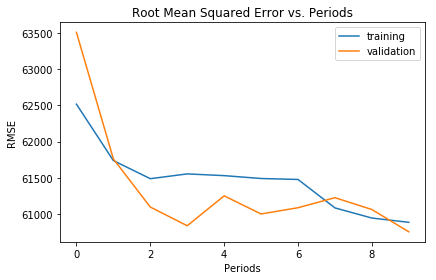

In [45]:
def location_location_location(examples_dataframe):
  """Returns a version of the input `DataFrame` that keeps only the SQMeter_price and Neighborhood."""
  processed_features = pd.DataFrame()
  processed_features["SQMeter_price"] = linear_scale(examples_dataframe["SQMeter_price"])
  processed_features["Neighborhood"] = linear_scale(examples_dataframe["Neighborhood"])
  return processed_features

lll_dataframe = location_location_location(preprocess_features(housing_dataframe))
lll_training_examples = lll_dataframe.head(1000)
lll_validation_examples = lll_dataframe.tail(500)

_ = train_nn_regression_model(
    my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
    steps=1000,
    batch_size=100,
    hidden_units=[10, 10, 5, 5, 5],
    training_examples=lll_training_examples,
    training_targets=training_targets,
    validation_examples=lll_validation_examples,
    validation_targets=validation_targets)